In [1]:
%pip install setuptools
%pip install ydata_profiling
%pip install scikit-learn
%pip install xlrd
%pip install openpyxl
%pip install ipywidgets
%pip install statsmodels
%pip install catboost

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from ydata_profiling import ProfileReport
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.tsa.stattools import adfuller
from catboost import CatBoostRegressor
import catboost
from catboost import *
import statsmodels.api as sm

In [3]:
excel_data=pd.read_excel("././dataset/Объёмы перевозок.xls", skiprows=[0], header=[0,1])
excel_data_volumes = excel_data

In [4]:
excel_data_volumes.sort_index(axis=1, inplace=True)
num_col=len(excel_data_volumes.columns)
left = excel_data_volumes.iloc[:, [num_col-5, num_col-4, num_col-3, num_col-2,num_col-1]]
left.columns = left.columns.get_level_values(1)
left = left.set_axis(["id", "subj_from", "subj_to", "cargo_code", "cargo_type"], axis = 1)

In [5]:
labelencodder = LabelEncoder()
subj = pd.concat([left.loc[:, ["subj_from"]].rename(columns = {"subj_from": "subj"}), left.loc[:, ["subj_to"]].rename(columns = {"subj_to": "subj"})]).drop_duplicates(ignore_index=True)
cargo_type = left.loc[:, ["cargo_type"]].drop_duplicates(ignore_index=True)
subj.to_excel("././dataset/subj.xlsx")
cargo_type.to_excel("././dataset/cargo_type.xlsx")

In [6]:
left.loc[:, ["subj_from"]] = left.loc[:, ["subj_from"]].apply(lambda x: subj[subj["subj"] == x["subj_from"]].index[0], axis=1)
left.loc[:, ["subj_to"]] = left.loc[:, ["subj_to"]].apply(lambda x: subj[subj["subj"] == x["subj_to"]].index[0], axis=1)
left.loc[:, ["cargo_type"]] = left.loc[:, ["cargo_type"]].apply(lambda x: cargo_type[cargo_type["cargo_type"] == x["cargo_type"]].index[0], axis=1)

In [7]:
left["subj_from"] = left["subj_from"].astype("int64")
left["subj_to"] = left["subj_to"].astype("int64")
left["cargo_type"] = left["cargo_type"].astype("int64")

In [8]:
for i in range(int((num_col-5)/2)):
    right = excel_data_volumes.iloc[:, [i*2,i*2+1]]
    date = pd.to_datetime(excel_data_volumes.iloc[:, [i*2]].columns.get_level_values(0).to_list()[0], format="%Y/%m")
    
    right.insert(2, ("", "date"), date)
    right.insert(3, ("", "month"), date.month)
    right.insert(4, ("", "quarter"), date.quarter)
    right.insert(5, ("", "year"), date.year)
    right.columns = right.columns.get_level_values(1)
    right = right.set_axis(["cargo_volume", "cargo_sales", "date", "month", "quarter", "year"], axis=1)
    right.insert(2, ("cargo_price"), right.apply(lambda x: (x["cargo_sales"] / x["cargo_volume"]) if x["cargo_volume"] > 0 else x["cargo_sales"], axis= 1))
    if i == 0:
        result = pd.concat([left, right], axis = 1, sort = False)
    else:
        result = pd.concat([result, pd.concat([left, right], axis = 1, sort = False)], axis = 0, ignore_index=True, sort=False)
excel_data_volumes = result

In [9]:
excel_data_volumes.insert(12, ("month_of_period"), 0)

In [10]:
min = excel_data_volumes["year"].min()
excel_data_volumes["month_of_period"] = excel_data_volumes["year"].apply(lambda x: x - min)*12 + excel_data_volumes["month"] 
excel_data_volumes = excel_data_volumes.drop("date", axis = 1)

In [11]:
excel_data_volumes.to_excel("././dataset/volumes.xlsx")

In [13]:
excel_data=pd.read_excel("././dataset/MC_1.xls", header=[0])
excel_data_MC = excel_data
excel_data=pd.read_excel("././dataset/MC_2.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_4.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_5.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_6.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_7.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)
excel_data=pd.read_excel("././dataset/MC_8.xls", header=[0])
excel_data_MC = pd.concat([excel_data_MC, excel_data], axis=0, ignore_index=True, sort=False)

In [14]:
excel_data_MC = excel_data_MC.drop(excel_data_MC.columns[[3,4,6,7,8,13,15,17]], axis = 1).drop_duplicates()
excel_data_MC = excel_data_MC.set_axis(["id", "is_msp", "company_size", "company_okved2", "els", "is_otpr", "is_poluch", "index_pl", "index_fin", "kontrakt_type"], axis=1)

In [15]:
excel_data_MC = excel_data_MC.dropna().drop_duplicates()

In [17]:
excel_data_MC["is_msp"] = excel_data_MC["is_msp"].apply(lambda x: 1 if x == "Да" else 0)
excel_data_MC["is_otpr"] = excel_data_MC["is_otpr"].apply(lambda x: 1 if x == "Да" else 0) 
excel_data_MC["is_poluch"] = excel_data_MC["is_poluch"].apply(lambda x: 1 if x == "Да" else 0) 

In [18]:
company_size = excel_data_MC.loc[:, ["company_size"]].drop_duplicates(ignore_index=True)
company_size.to_excel("././dataset/company_size.xlsx")
index_pl = excel_data_MC.loc[:, ["index_pl"]].drop_duplicates(ignore_index=True)
index_pl.to_excel("././dataset/index_pl.xlsx")
index_fin = excel_data_MC.loc[:, ["index_fin"]].drop_duplicates(ignore_index=True)
index_fin.to_excel("././dataset/index_fin.xlsx")
kontrakt_type = excel_data_MC.loc[:, ["kontrakt_type"]].drop_duplicates(ignore_index=True)
kontrakt_type.to_excel("././dataset/kontrakt_type.xlsx")

In [19]:
excel_data_MC.loc[:, ["company_size"]] = excel_data_MC.loc[:, ["company_size"]].apply(lambda x: company_size[company_size["company_size"] == x["company_size"]].index[0], axis=1)
excel_data_MC.loc[:, ["index_pl"]] = excel_data_MC.loc[:, ["index_pl"]].apply(lambda x: index_pl[index_pl["index_pl"] == x["index_pl"]].index[0], axis=1)
excel_data_MC.loc[:, ["index_fin"]] = excel_data_MC.loc[:, ["index_fin"]].apply(lambda x: index_fin[index_fin["index_fin"] == x["index_fin"]].index[0], axis=1)
excel_data_MC.loc[:, ["kontrakt_type"]] = excel_data_MC.loc[:, ["kontrakt_type"]].apply(lambda x: kontrakt_type[kontrakt_type["kontrakt_type"] == x["kontrakt_type"]].index[0], axis=1)

In [20]:
excel_data_MC = excel_data_MC.drop_duplicates()

In [21]:
company_okved2 = excel_data_MC.groupby("id").apply(lambda x: list(set(list(x["company_okved2"]))), include_groups=False)
company_okved2 = company_okved2.reset_index().set_axis(["id", "company_okved2"], axis=1)  

In [22]:
is_msp = excel_data_MC.groupby("id").apply(lambda x: max(x["is_msp"]), include_groups=False)
is_msp = is_msp.reset_index().set_axis(["id", "is_msp"], axis=1) 

In [23]:
company_size = excel_data_MC.groupby("id").apply(lambda x: max(x["company_size"]), include_groups=False)
company_size = company_size.reset_index().set_axis(["id", "company_size"], axis=1)     

In [24]:
els = excel_data_MC.groupby("id").apply(lambda x: max(x["els"]), include_groups=False)
els = els.reset_index().set_axis(["id", "els"], axis=1)  

In [25]:
is_otpr = excel_data_MC.groupby("id").apply(lambda x: max(x["is_otpr"]), include_groups=False)
is_otpr = is_otpr.reset_index().set_axis(["id", "is_otpr"], axis=1)  

In [26]:
is_poluch = excel_data_MC.groupby("id").apply(lambda x: max(x["is_poluch"]), include_groups=False)
is_poluch = is_poluch.reset_index().set_axis(["id", "is_poluch"], axis=1) 

In [27]:
index_pl = excel_data_MC.groupby("id").apply(lambda x: max(x["index_pl"]), include_groups=False)
index_pl = index_pl.reset_index().set_axis(["id", "index_pl"], axis=1) 

In [28]:
index_fin = excel_data_MC.groupby("id").apply(lambda x: max(x["index_fin"]), include_groups=False)
index_fin = index_fin.reset_index().set_axis(["id", "index_fin"], axis=1) 

In [29]:
kontrakt_type = excel_data_MC.groupby("id").apply(lambda x: list(set(list(x["kontrakt_type"]))), include_groups=False)
kontrakt_type = kontrakt_type.reset_index().set_axis(["id", "kontrakt_type"], axis=1) 

In [30]:
id = excel_data_MC["id"].drop_duplicates()
id = id.reset_index().drop(columns=["index"])

In [32]:
excel_data = pd.merge(id, is_msp, left_on="id", right_on="id")


In [33]:
excel_data = pd.merge(excel_data, company_size, left_on="id", right_on="id")

In [34]:
excel_data = pd.merge(excel_data, company_okved2, left_on="id", right_on="id")

In [35]:
excel_data = pd.merge(excel_data, els, left_on="id", right_on="id")

In [36]:
excel_data = pd.merge(excel_data, is_otpr, left_on="id", right_on="id")

In [37]:
excel_data = pd.merge(excel_data, is_poluch, left_on="id", right_on="id")

In [38]:
excel_data = pd.merge(excel_data, index_pl, left_on="id", right_on="id")

In [39]:
excel_data = pd.merge(excel_data, index_fin, left_on="id", right_on="id")

In [40]:
excel_data = pd.merge(excel_data, kontrakt_type, left_on="id", right_on="id")

In [41]:
excel_data_MC = excel_data

In [42]:
excel_data_MC.to_excel("././dataset/MC.xlsx")

In [44]:
data_pd = excel_data_volumes.drop("subj_from", axis = 1)
data_pd = data_pd.drop("subj_to", axis = 1)
data_pd = data_pd.drop("cargo_code", axis = 1)
data_pd = data_pd.drop("cargo_type", axis = 1)


In [45]:
data_pd = data_pd.groupby(["id", "month_of_period", "year", "quarter", "month" ], as_index=False).sum()

In [46]:
data_pd["innactive"] = 0
data_pd["active"] = 0
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd["active"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] > 0) & (x["cargo_sales"] > 0)) else 0, axis=1)

In [48]:
data_pd["outflow"] = 0

def calc_innactive(row):
    prev_row_value = 0
    row_value = data_pd.iloc[row.name]["innactive"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["innactive"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("innactive")] = prev_row_value + 1
                row_value = data_pd.iloc[row.name]["innactive"]
                if row_value > 11:
                    prev_row_value = 1
                else:
                    prev_row_value = row_value/12
            else: 
                prev_row_value = 0
    return prev_row_value

def calc_active(row):
    row_value = data_pd.iloc[row.name]["active"]
    row_id = data_pd.iloc[row.name]["id"]
    if row.name > 0:
        prev_row_id = data_pd.iloc[row.name - 1]["id"]
        if row_id == prev_row_id:
            if  row_value > 0:
                prev_row_value = data_pd.iloc[row.name - 1]["active"]
                data_pd.iloc[row.name, data_pd.columns.get_loc("active")] = prev_row_value + 1
    return 0

data_pd["outflow"] = data_pd.apply(calc_innactive, axis=1)
# data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd.apply(calc_active, axis=1)


0        0
1        0
2        0
3        0
4        0
        ..
30587    0
30588    0
30589    0
30590    0
30591    0
Length: 30592, dtype: int64

In [49]:
data_pd["innactive"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] == 0) & (x["cargo_sales"] == 0)) else 0, axis=1)
data_pd["active"] = data_pd.apply(lambda x: 1 if ((x["cargo_volume"] > 0) & (x["cargo_sales"] > 0)) else 0, axis=1)

In [50]:
excel_data = data_pd[data_pd["month_of_period"] == max(data_pd["month_of_period"])].loc[:, ["id", "outflow"]].reset_index()

In [51]:
excel_data = excel_data.drop(columns = ["index"])

In [52]:
excel_data["outflow"] = excel_data["outflow"].apply(lambda x: 1 if x ==1 else 0)

In [53]:
data_pd = data_pd.drop(columns = ["month_of_period", "year", "quarter", "month", "outflow"]).groupby(["id"]).sum()

In [54]:
data_pd["activity"] = data_pd.apply(lambda x: x["active"]/(x["active"]+x["innactive"]), axis = 1)

In [55]:
data_pd = data_pd.drop(columns=["innactive", "active"])

In [57]:
data_pd = pd.merge(data_pd, excel_data, left_on="id", right_on="id")

In [58]:
data_pd = data_pd.drop(columns=["cargo_price"])

In [59]:
data_pd = data_pd.rename(columns = {"outflow" : "out"})

In [66]:
excel_data = pd.merge(excel_data_MC, data_pd, left_on="id", right_on="id", how="inner")

In [75]:
excel_data.loc[:, ["company_okved2"]] = excel_data.loc[:, ["company_okved2"]].apply(lambda x: ', '.join(str(element) for element in x["company_okved2"]), axis=1)

In [76]:
company_okved2 = excel_data.loc[:, ["company_okved2"]].drop_duplicates(ignore_index=True)
company_okved2.to_excel("././dataset/company_okved2.xlsx")

In [77]:
excel_data.loc[:, ["company_okved2"]] = excel_data.loc[:, ["company_okved2"]].apply(lambda x: company_okved2[company_okved2["company_okved2"] == x["company_okved2"]].index[0], axis=1)

In [71]:
excel_data.loc[:, ["kontrakt_type"]] = excel_data.loc[:, ["kontrakt_type"]].apply(lambda x: ', '.join(str(element) for element in x["kontrakt_type"]), axis=1).astype("str")

In [72]:
kontrakt_type = excel_data.loc[:, ["kontrakt_type"]].drop_duplicates(ignore_index=True)
kontrakt_type.to_excel("././dataset/kontrakt_type.xlsx")

In [73]:
excel_data.loc[:, ["kontrakt_type"]] = excel_data.loc[:, ["kontrakt_type"]].apply(lambda x: kontrakt_type[kontrakt_type["kontrakt_type"] == x["kontrakt_type"]].index[0], axis=1)

In [79]:
excel_data = excel_data.convert_dtypes()
excel_data.to_excel("././dataset/merge_data.xlsx")

In [81]:
excel_data = excel_data.drop(columns=["is_otpr"])

In [83]:
excel_data["price"] = round(excel_data["cargo_sales"] / excel_data["cargo_volume"]).astype("int64")

In [84]:
excel_data["cargo_sales"] = np.log(excel_data["cargo_sales"])

In [85]:
excel_data["cargo_volume"] = np.log(excel_data["cargo_volume"])

In [86]:
excel_data = excel_data.convert_dtypes()

In [89]:
excel_data = excel_data[[c for c in excel_data if c not in ['out']] 
       + ['out']]

In [90]:
ProfileReport(excel_data, minimal = True) # Формирование отчета для исследования данных

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [92]:
excel_data.drop(columns = ["id", "els"]).groupby(by = "out").mean() # расчет средних значений признаков для тех кто ушел и остался

,is_msp,company_size,company_okved2,is_poluch,index_pl,index_fin,kontrakt_type,cargo_volume,cargo_sales,activity,price
out,,,,,,,,,,,
0,0.130435,0.913043,16.826087,0.913043,0.086957,0.326087,0.23913,9.402583,17.228368,0.769022,4428.282609
1,0.142857,1.0,23.857143,1.0,0.0,0.285714,0.0,6.654508,14.192543,0.133929,3013.0


<Axes: >

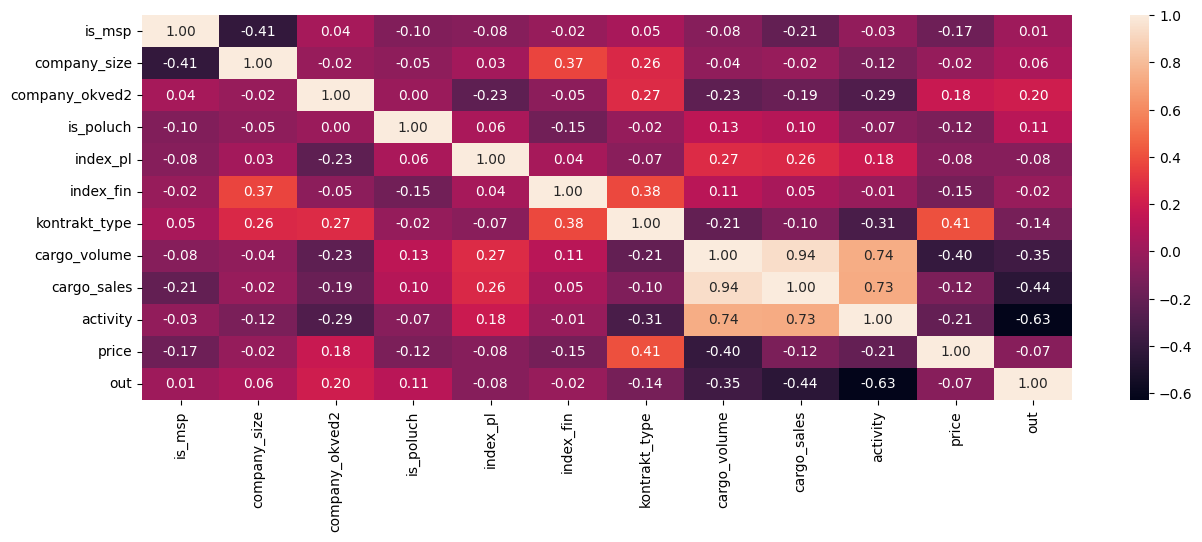

In [93]:
cor = excel_data.drop(columns = ["id", "els"]).corr() # матрица корреляций
fig, ax = plt.subplots(figsize=(15,5)) 
sns.heatmap(cor, annot = True, fmt = ".2f") # тепловая карта на основе матрицы корреляций

In [132]:
fit_pd = excel_data.drop(columns = ["els"])

In [138]:
keep = fit_pd['id'].sample(frac=0.8)
m = fit_pd['id'].isin(keep)
train = fit_pd[m].drop("id", axis=1)
test = fit_pd[~m].drop("id", axis=1)

train.to_excel("train.xlsx")
test.to_excel("test.xlsx")

In [ ]:
X_train = train.drop("out", axis = 1)
y_train = train["out"] # разделение данных на признаки (матрица X) и целевую переменную (y)
X_test = test.drop("out", axis = 1)
y_test = test["out"] # разделение данных на признаки (матрица X) и целевую переменную (y)

In [195]:
X = pd.concat([X_train, X_test], axis=0)

In [196]:
model = LogisticRegression(max_iter = 1000)  
model.fit(X_train,y_train)
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, predictions)
precision = precision_score (y_test, predictions)
recall = recall_score (y_test, predictions)
print(acc, precision, recall) # вывод на экран метрик, характеризующих качество модели

1.0 1.0 1.0


In [197]:
rf_model = RandomForestClassifier(n_estimators = 100)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test) 
acc_rf = accuracy_score(y_test, y_pred)
precision_rf = precision_score (y_test, y_pred)
recall_rf = recall_score (y_test, y_pred)
print(acc_rf, precision_rf, recall_rf)# вывод на экран метрик, характеризующих качество модели

1.0 1.0 1.0


In [198]:
predictions = model.predict(X)

In [199]:
df = pd.DataFrame(predictions, columns =['out'])

In [202]:
X = pd.concat([X.reset_index(), df], axis=1).drop(columns = ["index"])

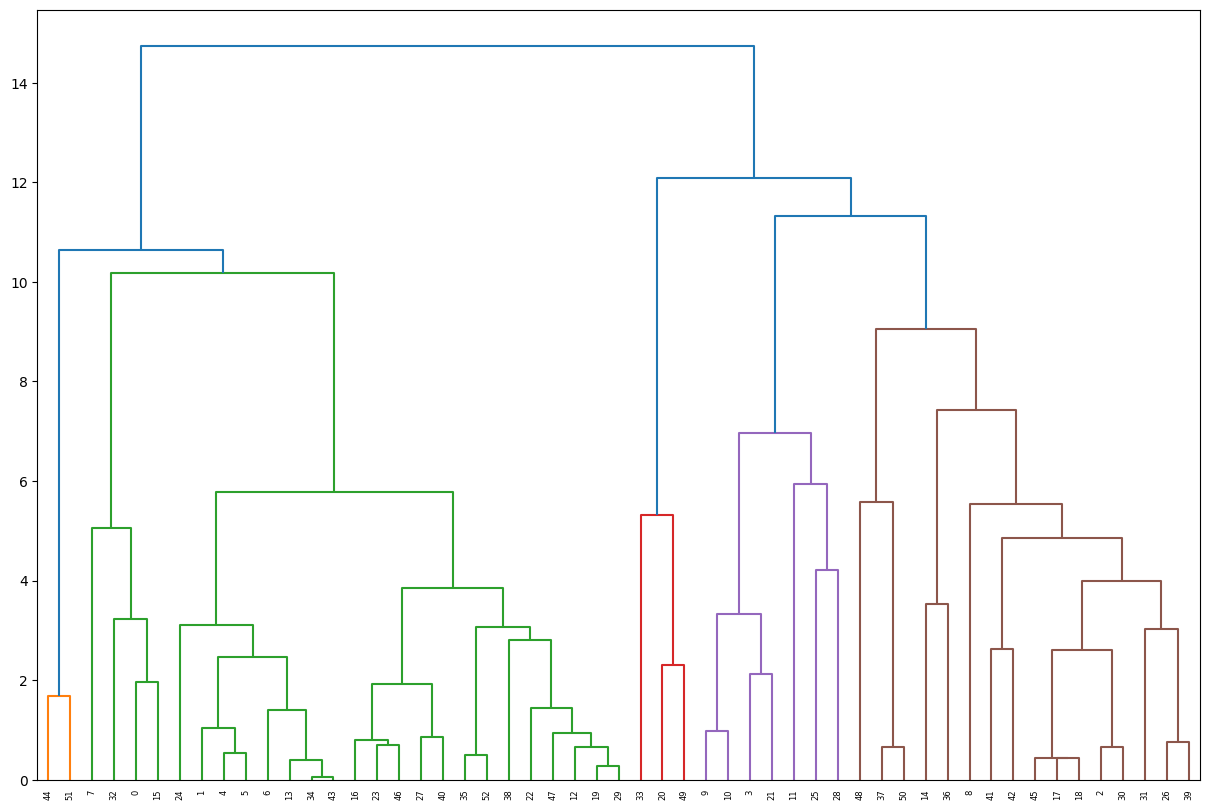

In [203]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
linked = linkage(X_sc, method = "ward")
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation="top")
plt.show() # вывод на экран дендрограммы

In [204]:
cl = 5 # количество кластеров выбранов соответствии с дендрограммой, а также на основе анализа нескольких вариантов
km = KMeans(n_clusters = cl)
labels = km.fit_predict(X_sc)

In [205]:
X["claster"]= labels # добавление колонки с категориями

In [206]:
piv = pd.pivot_table(data = X, index = "claster", columns = "out", values = "activity", aggfunc = "count" ).reset_index() # формирование сводной таблицы для анализа оттока по категориям
piv.columns = ["claster","out_0","out_1"]
piv["perc"] = piv["out_1"]/(piv["out_0"]+piv["out_1"])
piv["number"]=piv["out_1"]+piv["out_0"]
print(piv.head())

   claster  out_0  out_1  perc  number
0        0      3   <NA>  <NA>    <NA>
1        1      8   <NA>  <NA>    <NA>
2        2     12      3   0.2      15
3        3     22   <NA>  <NA>    <NA>
4        4      5   <NA>  <NA>    <NA>


<Axes: >

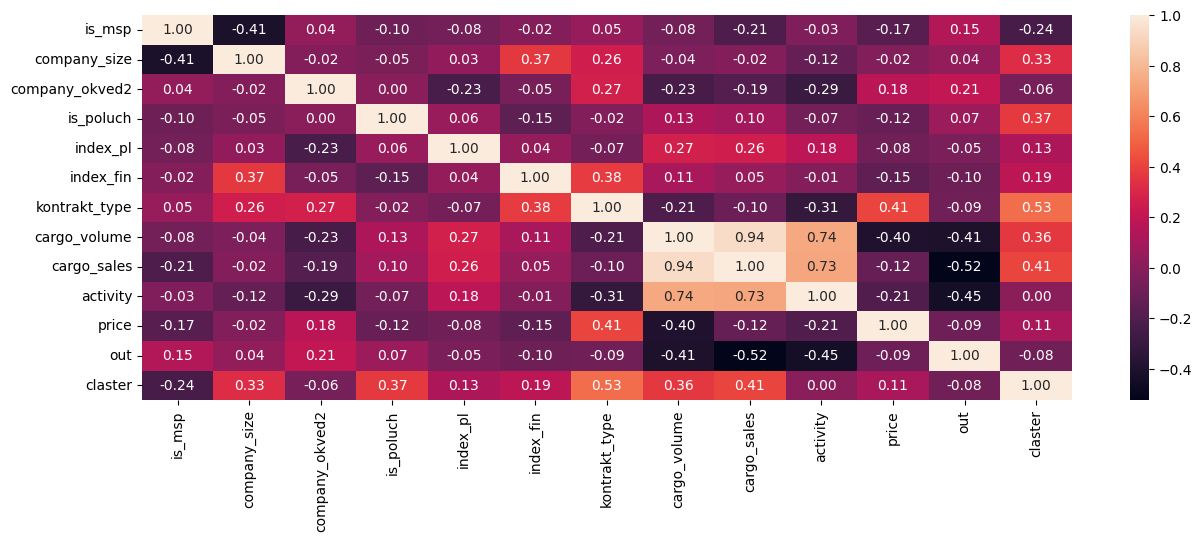

In [207]:
cor = X.corr()
fig, ax = plt.subplots(figsize=(15,5))
sns.heatmap(cor, annot = True, fmt = ".2f")

In [208]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   is_msp          53 non-null     Int64  
 1   company_size    53 non-null     Int64  
 2   company_okved2  53 non-null     Int64  
 3   is_poluch       53 non-null     Int64  
 4   index_pl        53 non-null     Int64  
 5   index_fin       53 non-null     Int64  
 6   kontrakt_type   53 non-null     Int64  
 7   cargo_volume    53 non-null     Float64
 8   cargo_sales     53 non-null     Float64
 9   activity        53 non-null     Float64
 10  price           53 non-null     Int64  
 11  out             53 non-null     float64
 12  claster         53 non-null     int32  
dtypes: Float64(3), Int64(8), float64(1), int32(1)
memory usage: 5.9 KB


In [209]:
X.to_excel("././dataset/output.xlsx")